In [21]:
# importing dependencies
import pandas as pd # data frame
import numpy as np # matrix math
from scipy.io import wavfile # reading the wavfile
import os # interation with the OS
from sklearn.utils import shuffle # shuffling of data
from random import sample # random selection
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # to view graphs
import wave
from math import log, floor
# audio processing
from scipy import signal # audio processing
from scipy.fftpack import dct
import librosa # library for audio processing
import numpy as np
import pandas as pd
from sklearn.decomposition import *
from sklearn.cluster import KMeans
import sys, os
import pickle
import tqdm ##
from tqdm import * ##

In [6]:
SAMPLE_RATE = 44100
fname = 'data/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=400)
mfcc.shape

(400, 173)

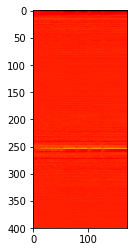

In [14]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');
# mfcc

In [2]:
#config
class Config(object):
    def __init__(self,
                 sampling_rate=44100, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [36]:
def prepare_data_old(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1)) #MFCC
#     X = np.empty(shape=(df.shape[0], 64, 88, 1)) #FBANK
    input_length = config.audio_length
    for i, fname in tqdm(enumerate(df.fname)):
#         print(fname)
        file_path = data_dir + str(fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:  # 輸入值>設定值
            max_offset = len(data) - input_length
#             offset = np.random.randint(max_offset)
            offset = int(max_offset / 2) #太長就只取中間
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data): # 設定值>輸入值
                max_offset = input_length - len(data)
                offset = int(max_offset / 2)
#                 offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
#             data = np.pad(data, (offset,offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
#         data = librosa.feature.melspectrogram(data,sr=config.sampling_rate,n_fft=config.sampling_rate,n_mels=64)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
#     print(audio_duration,n_mfcc)
    return X


In [66]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], 15, 1034, 1))
    input_length = config.audio_length
    for i, fname in tqdm(enumerate(df.fname)):
#         print(fname)
        file_path = data_dir + str(fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [4]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-8)
    return data-0.5

In [18]:
def prepare_data_raw(df, config, data_dir):
    cur_batch_size = len(df)
#     X = np.empty(cur_batch_size, *config.dim)
    X = np.empty(shape=(df.shape[0], config.dim[0])) #, config.dim[1]
    input_length = config.audio_length
    for i, fname in enumerate(df.fname):
        print(fname)
        file_path = data_dir + str(fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:  # 輸入值>設定值
            max_offset = len(data) - input_length
#             offset = np.random.randint(max_offset)
            offset = int(max_offset / 2) #太長就只取中間
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data): # 設定值>輸入值
                max_offset = input_length - len(data)
                offset = int(max_offset / 2)
#                 offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            data = audio_norm(data)#[:, np.newaxis]
#             data = np.pad(data, (offset,offset), "constant")

#         data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
#         data = librosa.feature.melspectrogram(data,sr=config.sampling_rate)
#         data = np.expand_dims(data, axis=-1)
        X[i,] = data
#     print(audio_duration,n_mfcc)
    return X


In [ ]:
train = pd.read_csv("data/train_label.csv")
test = pd.read_csv("data/sample_submission.csv")
config = Config(sampling_rate=44100, audio_duration=4, n_folds=10, 
                learning_rate=0.001, use_mfcc=False, n_mfcc=64) #mfcc=4,40 , fbank=12,128 audio_duration,audio_duration

In [33]:
X_train = prepare_data_raw(train, config, 'data/audio_train/')
X_test = prepare_data_raw(test, config, 'data/audio_test/')
print(X_train.shape , X_test.shape)

00044347.wav
001ca53d.wav
002d256b.wav
0033e230.wav
00353774.wav
003b91e8.wav
003da8e5.wav
0048fd00.wav
004ad66f.wav
0063ab88.wav
006f2f32.wav
0075d39c.wav
00780200.wav
0079d310.wav
0091fc7f.wav
0097160c.wav
00ad7068.wav
00c5808a.wav
00c82919.wav
00c934d7.wav
00c9e799.wav
00cb787c.wav
00ce569f.wav
00d1fe46.wav
00d3bba3.wav
00d40fa2.wav
00d9fa61.wav
00e2b4cd.wav
00f88dc5.wav
00fbb28b.wav
00fcbab2.wav
010aa387.wav
011a2185.wav
0120d246.wav
01235a12.wav
01257aad.wav
01302128.wav
013264d3.wav
013c3135.wav
01506d76.wav
015cf474.wav
0160d55e.wav
01638f61.wav
0172a2a5.wav
017ea24e.wav
01811e48.wav
0184c390.wav
018863f5.wav
018a10bb.wav
018b1df6.wav
018d1dc4.wav
0193042e.wav
01974c7c.wav
019aae9d.wav
019d2a2c.wav
01a36643.wav
01a39e95.wav
01a59a61.wav
01a59c11.wav
01a5dc85.wav
01b9f44a.wav
01c2f88b.wav
01d2475c.wav
01d4dafd.wav
01df7ada.wav
01e723f5.wav


KeyboardInterrupt: 

In [9]:
# X_train.shape
# X_train, X_test = normalize(X_train, X_test) #??

np.save('feature/raw/X_train.npy',X_train)
np.save('feature/raw/X_test.npy',X_test)
print(X_train.shape,X_test.shape)

(9473, 88200) (9400, 88200)


In [27]:
def normalize(X_all, X_test):
    # Feature normalization with train and test X
    X_train_test = np.concatenate((X_all, X_test))
    mu = (sum(X_train_test) / X_train_test.shape[0])
    sigma = np.std(X_train_test, axis=0)
    mu = np.tile(mu, (X_train_test.shape[0], 1))
    sigma = np.tile(sigma, (X_train_test.shape[0], 1))
    X_train_test_normed = (X_train_test - mu) / (sigma+1e-20)

    # Split to train, test again
    X_all = X_train_test_normed[0:X_all.shape[0]]
    X_test = X_train_test_normed[X_all.shape[0]:]
    return X_all, X_test

## MFCC / Fbank

In [ ]:
X_train = prepare_data(train, config, 'data/audio_train/')
X_test = prepare_data(test, config, 'data/audio_test/')
# y_train = to_categorical(train.label_idx, num_classes=config.n_classes)

9473it [07:31, 20.99it/s]
6226it [04:52, 21.32it/s]

In [ ]:
np.save('feature/mfcc5/X_train.npy',X_train)
np.save('feature/mfcc5/X_test.npy',X_test)

In [125]:
X_train = np.load('feature/fbank/X_train.npy')

In [124]:
X_train.shape #9473個音擋，時間長度1034，一個時間點有40個維度表示，kernel size=(4,47)or(4,22)
#反過來應該比較好，先時間維度再頻率維度，過完CNN再接LSTM，kernel size也反過來
#mfcc

(9473, 40, 345, 1)

In [126]:
X_train.shape #9473個音擋，時間長度1034，一個時間點有40個維度表示，kernel size=(4,47)or(4,22)
#反過來應該比較好，先時間維度再頻率維度，過完CNN再接LSTM，kernel size也反過來
#fbank

(9473, 128, 1034, 1)

In [78]:
len(X_train[1][0])

1034

In [90]:
pd.DataFrame(X_train[0].reshape(40,517))

,0,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,513,514,515,516
0,-404.827075,-408.867114,-413.631904,-410.081586,-412.734349,-417.249715,-418.035430,-424.961303,-421.487859,-415.926004,...,-604.858415,-603.315573,-605.861747,-603.500779,-603.838607,-604.494755,-603.968737,-609.858063,-605.336862,-599.240915
1,123.454821,124.556509,123.261416,128.514474,126.845222,121.922068,120.546849,115.970140,118.190932,121.935680,...,123.321431,124.690028,127.422208,130.896420,127.550998,124.095788,125.182313,123.367658,128.455115,134.123645
2,-121.682373,-126.048566,-129.207971,-131.519374,-134.526239,-135.384041,-134.068626,-130.223002,-133.717314,-133.051237,...,-51.095883,-49.487523,-46.922654,-47.219929,-50.058850,-53.559015,-49.665650,-49.591340,-51.480756,-51.598036
3,28.245849,28.231121,23.070098,18.908831,19.358378,23.906688,26.346000,28.141307,25.735918,25.268531,...,-26.363572,-24.901056,-26.908958,-28.405016,-25.451599,-27.771405,-26.071037,-26.309177,-30.077223,-31.173233
4,-20.933706,-22.711447,-25.701219,-27.550628,-29.980741,-27.382716,-26.970305,-27.143505,-23.630370,-23.853641,...,16.800442,16.626738,14.862820,15.269488,17.267773,17.624594,18.912312,17.440228,16.713732,13.907760
5,-19.677574,-16.863047,-20.714526,-22.222436,-21.518304,-23.251495,-26.308576,-28.137334,-22.832247,-21.376848,...,-15.862887,-16.326885,-16.255685,-16.556771,-16.307283,-15.794023,-13.773662,-15.043200,-13.090009,-16.075059
6,-7.084772,-4.861116,-6.822113,-9.235041,-4.979506,-3.851596,-8.008601,-11.973296,-9.245833,-10.794092,...,-14.993801,-14.843630,-13.063865,-17.039121,-14.035657,-11.415864,-12.788575,-13.780041,-11.326204,-12.644699
7,-19.472519,-18.677947,-22.095506,-23.307257,-20.456782,-19.239128,-18.874091,-20.362800,-18.391724,-23.509635,...,-6.788479,-3.079695,-1.410913,-2.321000,-2.986601,-2.714644,0.578577,1.077956,0.596537,-4.003604
8,-0.525379,-3.588846,-9.802688,-11.433818,-10.770132,-9.881114,-8.127094,-2.599342,-0.202395,-4.406295,...,-6.668925,-3.073193,-5.422101,-5.971793,-4.869401,-9.096387,-6.025456,-7.606296,-6.960982,-5.140701
9,-7.393700,-13.668729,-18.488884,-20.357031,-17.671018,-15.568677,-16.126588,-15.328059,-11.876423,-13.671763,...,5.656447,7.401848,9.189978,10.271817,6.775383,3.376421,5.586623,3.154571,2.204324,3.912223


# Analyze

In [91]:
train = pd.read_csv("data/train_label.csv")
test = pd.read_csv("data/sample_submission.csv")
train['nframes'] = train['fname'].apply(lambda f: wave.open('data/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/audio_test/' + f).getnframes())

In [92]:
me = pd.merge(train,test,how='outer',left_on=['fname','nframes'],right_on=['fname','nframes'])
me = me.filter(['fname','nframes'])
me

,fname,nframes
0,00044347.wav,617400
1,001ca53d.wav,455112
2,002d256b.wav,19404
3,0033e230.wav,352800
4,00353774.wav,199332
5,003b91e8.wav,585648
6,003da8e5.wav,59976
7,0048fd00.wav,45864
8,004ad66f.wav,308700
9,0063ab88.wav,1307124


In [110]:
q3 = me['nframes'].quantile(0.75)
q1 = me['nframes'].quantile(0.25)
q2 = me['nframes'].quantile(0.5)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
mean = me['nframes'].mean()
std = me['nframes'].std()
print(upper,lower) #train+test離群值
print(q1,q2,q3)
print(mean+std,mean-std,mean+0.94389*std,mean-0.94389*std,mean+0.99*std,mean-0.99*std)
print(mean,std)

799533.0 -368235.0
69678.0 184338.0 361620.0
551798.9563401975 -2315.5266787764267 536253.2745191002 13230.155142320873 549028.3839251027 455.04573631845415
274741.71483071055 277057.241509487


In [98]:
me[me['nframes']<3225] #超過upper bound離群值有1291筆(train+test)

,fname,nframes
9861,0b0427e2.wav,0
13482,6ea0099f.wav,0
16076,b39975f5.wav,0


In [106]:
me['nframes'].quantile(0.0002)

13230.0

In [109]:
(mean-13230)/std

0.9438905599648652

# Split

#### only keep manual verified data

In [2]:
train = pd.read_csv("data/train_label.csv")
# test = pd.read_csv("data/sample_submission.csv")
type_ = 'raw' #fbank
X_train = np.load('feature/'+type_+'/X_train.npy')
# X_test = np.load('feature/'+type_+'/X_test.npy')
X_train.shape

(9473, 352800)

In [3]:
train = pd.merge(train,pd.DataFrame(X_train),how='inner',right_index=True,left_index=True)
train

,fname,label,manually_verified,0,1,2,3,4,5,6,...,352790,352791,352792,352793,352794,352795,352796,352797,352798,352799
0,00044347.wav,Hi-hat,0,0.026581,0.019714,0.009613,0.001617,-0.001038,0.002716,0.009369,...,-0.000305,-0.000458,-0.000610,-0.000580,-0.000610,-0.000580,-0.000397,-0.000366,-0.000366,-0.000275
1,001ca53d.wav,Saxophone,1,0.020721,0.031494,0.041992,0.051727,0.061340,0.071289,0.081573,...,-0.060181,-0.058136,-0.055908,-0.053375,-0.050415,-0.047363,-0.044495,-0.041992,-0.039764,-0.038086
2,002d256b.wav,Trumpet,0,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,...,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456,-0.021456
3,0033e230.wav,Glockenspiel,1,0.014265,0.014882,0.016669,0.010198,0.011246,0.016052,0.014512,...,0.014265,0.014204,0.014265,0.014265,0.014142,0.014265,0.014142,0.014265,0.014265,0.014265
4,00353774.wav,Cello,1,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,...,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666,0.019666
5,003b91e8.wav,Cello,0,-0.015747,-0.012421,-0.008972,-0.005402,-0.001709,0.002167,0.006104,...,-0.096527,-0.099426,-0.102692,-0.105865,-0.109009,-0.112305,-0.115601,-0.118744,-0.121704,-0.124420
6,003da8e5.wav,Knock,1,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,...,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559,-0.046559
7,0048fd00.wav,Gunshot_or_gunfire,1,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007
8,004ad66f.wav,Clarinet,0,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,...,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139,-0.025139
9,0063ab88.wav,Computer_keyboard,0,0.001709,-0.002533,-0.004181,-0.002991,0.000244,0.002899,0.001617,...,-0.000183,-0.000336,-0.000153,-0.000153,-0.000305,-0.000244,0.000183,0.000702,0.000977,0.000641


In [4]:
train = train[train['manually_verified']==0]
X_train = np.array(train.drop(['fname','label','manually_verified'],axis=1))
X_train.shape

(5763, 352800)

In [5]:
np.save('feature/'+type_+'X_train_unverified_5763.npy',X_train)

In [2]:

def split_valid_set(X_all, Y_all, percentage):
    all_data_size = len(X_all)
    valid_data_size = int(floor(all_data_size * percentage))

    X_all, Y_all = _shuffle(X_all, Y_all)

    X_train, Y_train = X_all[0:valid_data_size], Y_all[0:valid_data_size]
    X_valid, Y_valid = X_all[valid_data_size:], Y_all[valid_data_size:]

    return X_train, Y_train, X_valid, Y_valid

In [3]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
#     print(X.shape, Y.shape)
    return (X[randomize], Y[randomize])

In [195]:
type_ = 'fbank' #fbank
X_train = np.load('feature/'+type_+'/X_train.npy')
train = pd.read_csv("data/train_label.csv")

In [200]:
round_ = 3 #0=>valid 20%, 3=>training 80%

In [201]:
if round_ ==0: #test,valid
    X_train, Y_train, X_valid, Y_valid = split_valid_set(X_train, train['fname'], 0.8) #Y_train0.9,2/3
    print(X_valid.shape,Y_valid.shape)
elif round_ == 1: #train1, valid
    Y_train = Y_train.to_frame().reset_index()
    X_train, Y_train, X_valid, Y_valid = split_valid_set(X_train, Y_train['fname'], 2/3) #Y_train0.9,2/3
    print(round_,X_valid.shape,Y_valid.shape)
elif round_ == 2: #train2, valid
    Y_train = Y_train.to_frame().reset_index()
    X_train, Y_train, X_valid, Y_valid = split_valid_set(X_train, Y_train['fname'], 1/2) #Y_train0.9,2/3
    print(round_,X_valid.shape,Y_valid.shape)
else: #train3, train
    print(round_,X_train.shape,Y_train.shape)



3 (7578, 128, 1034, 1) (7578,)


In [202]:
if round_ ==0 or round_==1 or round_==2:
    valid = pd.merge(Y_valid.to_frame(),train,how='left',on=['fname'],left_index=True)
    print(round_,valid)
elif round_ ==3 :
    valid = pd.merge(Y_train.to_frame(),train,how='left',left_on=['fname'],right_on=['fname'],left_index=True)
    print(round_,valid)
    


3              fname               label  manually_verified
391   0b436682.wav     Acoustic_guitar                  0
2025  37e5557d.wav           Harmonica                  1
7510  cc158878.wav             Shatter                  1
4891  83c449b0.wav     Acoustic_guitar                  0
1568  2b0c0c90.wav          Tambourine                  1
5010  8755f4f5.wav            Laughter                  0
998   1b8de009.wav                Fart                  0
4715  7f80d12f.wav               Cough                  0
7522  cc5662e7.wav               Flute                  0
1361  258777c8.wav               Flute                  0
9270  fa842956.wav               Knock                  0
9153  f7335046.wav               Knock                  0
5603  98aeddbf.wav            Clarinet                  1
1841  330ba9ae.wav               Knock                  0
4146  700f6042.wav         Double_bass                  0
7815  d3ede893.wav            Applause                  1
6750  b809aa

In [136]:
# len(X_valid) , len(Y_valid)
# train['fname']
# type(Y_train)
# Y_valid

2822    b88307d9.wav
3180    f7c0ebf8.wav
3860    bf644d3f.wav
4488    a1a41c2c.wav
62      9fcbf5c6.wav
6060    33f31906.wav
3409    afe33168.wav
1412    285a1825.wav
1791    642aba58.wav
4989    3874b7b5.wav
381     f1a0a22a.wav
2044    75498e93.wav
2403    84c51120.wav
837     ffbba18f.wav
6821    448d0cb1.wav
4770    82f235fc.wav
3132    35fb9b2e.wav
7432    237b9e2a.wav
315     5002939d.wav
2727    385e9493.wav
2235    9d868658.wav
7052    20fb2252.wav
2819    f5fb5cd1.wav
6739    391dea43.wav
6278    0939d783.wav
3931    48553cdd.wav
4300    b5ab5cdc.wav
2602    5f3186c8.wav
1025    c683f28f.wav
7439    8dccb289.wav
            ...     
7907    a2d66bee.wav
5619    69fe3102.wav
7537    9e1ed2eb.wav
3820    67eceec7.wav
7608    b0fba6dc.wav
8186    788f5993.wav
2161    a31c843d.wav
7300    93519b51.wav
6925    099ce615.wav
2769    990e6fc3.wav
8469    a44fc9e6.wav
2818    d0ac8e53.wav
2760    104f8672.wav
2516    7c07d9a2.wav
8206    540cd3bc.wav
3723    a2d8cc0e.wav
6370    9684f

In [203]:
if round_ ==0:
    valid.to_csv('data/phase1/'+type_+'/test/test_Y.csv',index=True) #改
    np.save('data/phase1/'+type_+'/test/test_X.npy',X_valid) #改*2
elif round_ == 3:
    valid.to_csv('data/phase1/'+type_+'/train'+str(round_)+'/train'+str(round_)+'_Y.csv',index=True) #改
    np.save('data/phase1/'+type_+'/train'+str(round_)+'/train'+str(round_)+'_X.npy',X_train) #改*2
else:
    valid.to_csv('data/phase1/'+type_+'/train'+str(round_)+'/train'+str(round_)+'_Y.csv',index=True) #改
    np.save('data/phase1/'+type_+'/train'+str(round_)+'/train'+str(round_)+'_X.npy',X_valid) #改*2

In [56]:
train.reset_index(drop=True)
valid.reset_index(drop=True)
train2 = train[train['fname'] not in  valid.fname.values]
train2

ValueError: Lengths must match to compare

In [205]:
np.load('data/phase1/fbank/train3/train3_X.npy').shape

(7578, 128, 1034, 1)

In [17]:
df = pd.DataFrame()
df['fname']=Y_valid
df['feature']=pd.Series([X_valid],index=df.index)
df

,fname,feature
3837,67909683.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
7713,d126054d.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
6524,b272072e.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
4695,7ef2c8e9.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
8232,deb87700.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
5987,a329f591.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
7590,cdfc8967.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
3985,6b192226.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
6684,b67dbbb6.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."
8337,e1a612af.wav,"[[[[0.], [0.], [0.], [0.], [0.], [0.], [0.], [..."


In [18]:
df.iloc[0,1].

(948, 128, 1034, 1)

In [133]:
train

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1
5,003b91e8.wav,Cello,0
6,003da8e5.wav,Knock,1
7,0048fd00.wav,Gunshot_or_gunfire,1
8,004ad66f.wav,Clarinet,0
9,0063ab88.wav,Computer_keyboard,0


In [135]:
df

,fname
0,00044347.wav
1,001ca53d.wav
2,002d256b.wav
3,0033e230.wav
4,00353774.wav
5,003b91e8.wav
6,003da8e5.wav
7,0048fd00.wav
8,004ad66f.wav
9,0063ab88.wav


# PCA

In [3]:
type_ = 'raw' #fbank
X_train = np.load('feature/'+type_+'/X_train.npy')
X_test = np.load('feature/'+type_+'/X_test.npy')

In [3]:
# print(X_train.shape)
X_train = np.swapaxes(X_train,2,1)
X_test = np.swapaxes(X_test,2,1)
X_train = X_train.reshape((9473,-1))
X_test = X_test.reshape((9400,-1))
print(X_train.shape,X_test.shape)
X_test = np.concatenate((X_train, X_test))
# print(X_train.shape)

(9473, 132352) (9400, 132352)


In [4]:
# pca = KernelPCA(n_components=1,kernel='rbf',fit_inverse_transform=False,remove_zero_eig=True,copy_X=True,random_state=725035,n_jobs=-1) #n_components='mle',395
pca = PCA(n_components=6,iterated_power='auto', whiten=True,svd_solver="full",random_state=182983)
# kernel =  “poly” | “rbf” | “sigmoid” | “cosine” 
# arpack=>RAW randomized 
all_X_PCA = pca.fit_transform(X_test)
X_train, X_test = all_X_PCA[0:X_train.shape[0]] , all_X_PCA[X_train.shape[0]:]
print(X_train.shape,X_test.shape)
# print(all_X_PCA.shape)

(9473, 6) (9400, 6)


In [5]:
np.save('feature/fbank/pca/train_X_PCA.npy',X_train)
np.save('feature/fbank/pca/test_X_PCA.npy',X_test)

In [6]:
all_X_PCA[0] #cosine > rbf > poly >sigmoid

array([-0.16262026, -0.07543593, -0.02728481, -0.03296018,  0.01613782,
        0.10017397])

In [ ]:
def normalize(X_all, X_test):
    # Feature normalization with train and test X
    X_train_test = np.concatenate((X_all, X_test))
    mu = (sum(X_train_test) / X_train_test.shape[0])
    sigma = np.std(X_train_test, axis=0)
    mu = np.tile(mu, (X_train_test.shape[0], 1))
    sigma = np.tile(sigma, (X_train_test.shape[0], 1))
    X_train_test_normed = (X_train_test - mu) / (sigma+1e-20)

    # Split to train, test again
    X_all = X_train_test_normed[0:X_all.shape[0]]
    X_test = X_train_test_normed[X_all.shape[0]:]
    return X_all, X_test